In [1]:
import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann

#data integration package
#import scIB 
import scanpy.external as sce

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

#import rpy2.rinterface_lib.callbacks
import logging

#from rpy2.robjects import pandas2ri
#import anndata2ri


sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

In [3]:
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)
from batchglm.pkg_constants import TF_CONFIG_PROTO

/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/icb/carlo.dedonno/python/lib/python3.6/site-packages

batchglm version v0.7.1+31.g5707d0a
diffpy version v0.7.1+21.gcfbcbfc


In [4]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12

# Introduction

In this notebook, we perform differential expression tests on early life stress data from the Chen lab. The full dataset consists of 12 samples from 4 conditions (n=3 in all conditions). In particular, the mice encountered stress in two stages of life (early life stress and as adult). Thus, the 4 conditions are
1. BL_ctrl (baseline) - never stressed
2. ELS_ctrl (early life stress) - stressed only once
3. BL_stress - stressed only once
4. ELS_stress - stressed twice

We want to find out, how early life stress affected the mice as adults; split by cell type. 

We perform the following steps:
1. Load the data
2. Subset to the respective groups of interest
3. Run pairwise tests with DiffxPy

We agreed to perform the following analyses, pairwise for each condition, using diffxpy:

Test only on cell type level. 
	- Astrocytes
	- Microglia
	- Oligodendrocytes (mature)
	- Endothelial
	- Neurons_Glutamatergic (keep subclustering for testing)
	- Macrophages
	- … all other

Characterise Glutamatergic Neurons via differential expression.

Pseudotime analysis (later):
	- Neurons (Glia - NPC - Neuron or Astrocyte)
	- Oligodendrocytes

# Load data

In [5]:
adata_norm = sc.read('./data/data_norm.h5ad')
adata = sc.read('./data/cellxgene.h5ad')

In [6]:
adata.rename_categories('louvain', ['Astro 1', 'Oligo 1', 'CCK 1', 'Oligo 2', 'Glut 1', 'Endothelial',\
                                    'Glut 2', 'Microglia 1', 'OPCs', 'Microglia 2', \
                                    'CCK 2 (?)', 'Pericytes', 'Glut 3', 'CCK 3', 'GABA', \
                                    'Endothelial 2', 'Astro 2', 'Cajal-Retzius', 'Astro 3', \
                                    'Neurons (?)', 'Oligo (?)', 'Choroid Plexus', 'Ependymal', \
                                    'CCK 4', 'NPCs', 'Vascular', 'Macrophages', 'Meningeal', '??'])
adata_norm.obs = adata.obs

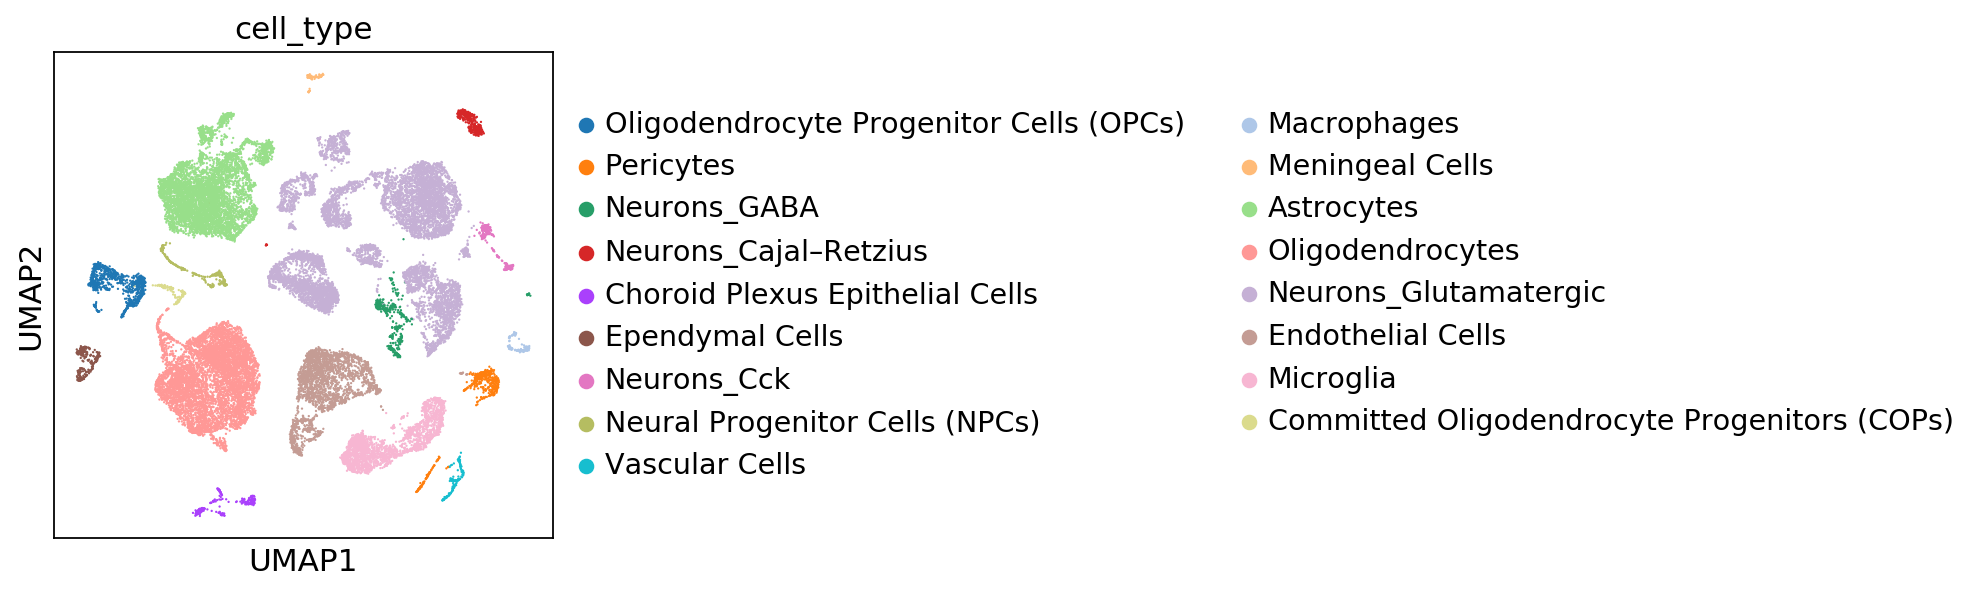

In [7]:
sc.pl.umap(adata, color='cell_type')

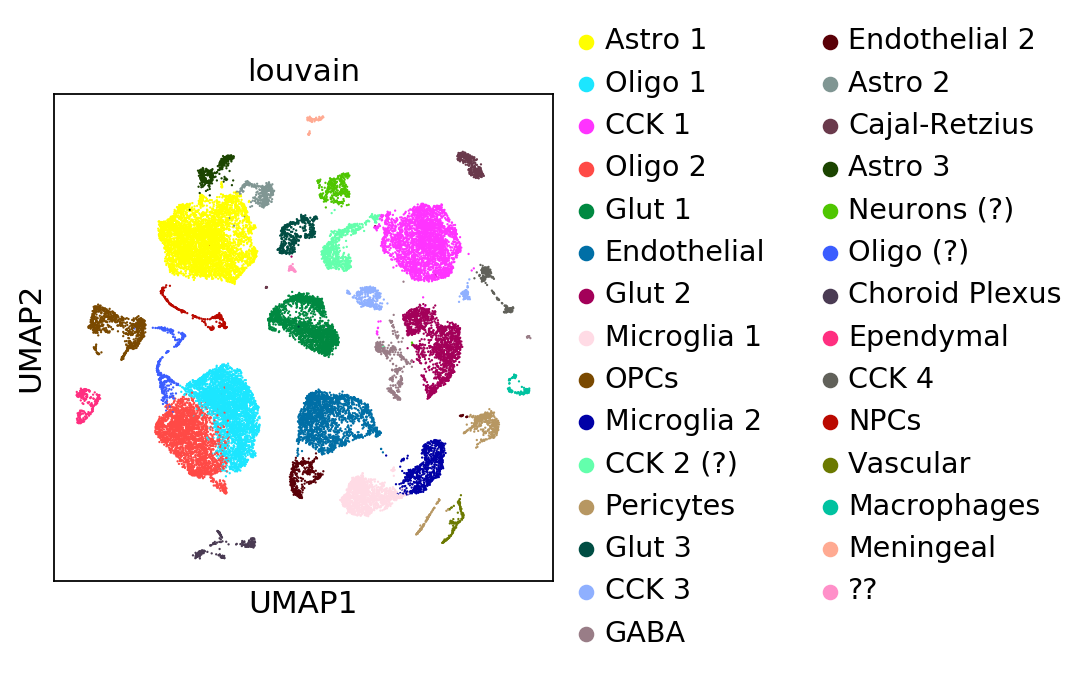

In [8]:
sc.pl.umap(adata, color='louvain')

# Differential expression tests

The following differential tests helps us to understand the cell type characteristics. 

In [9]:
sc.tl.rank_genes_groups(adata, 'louvain')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:39)


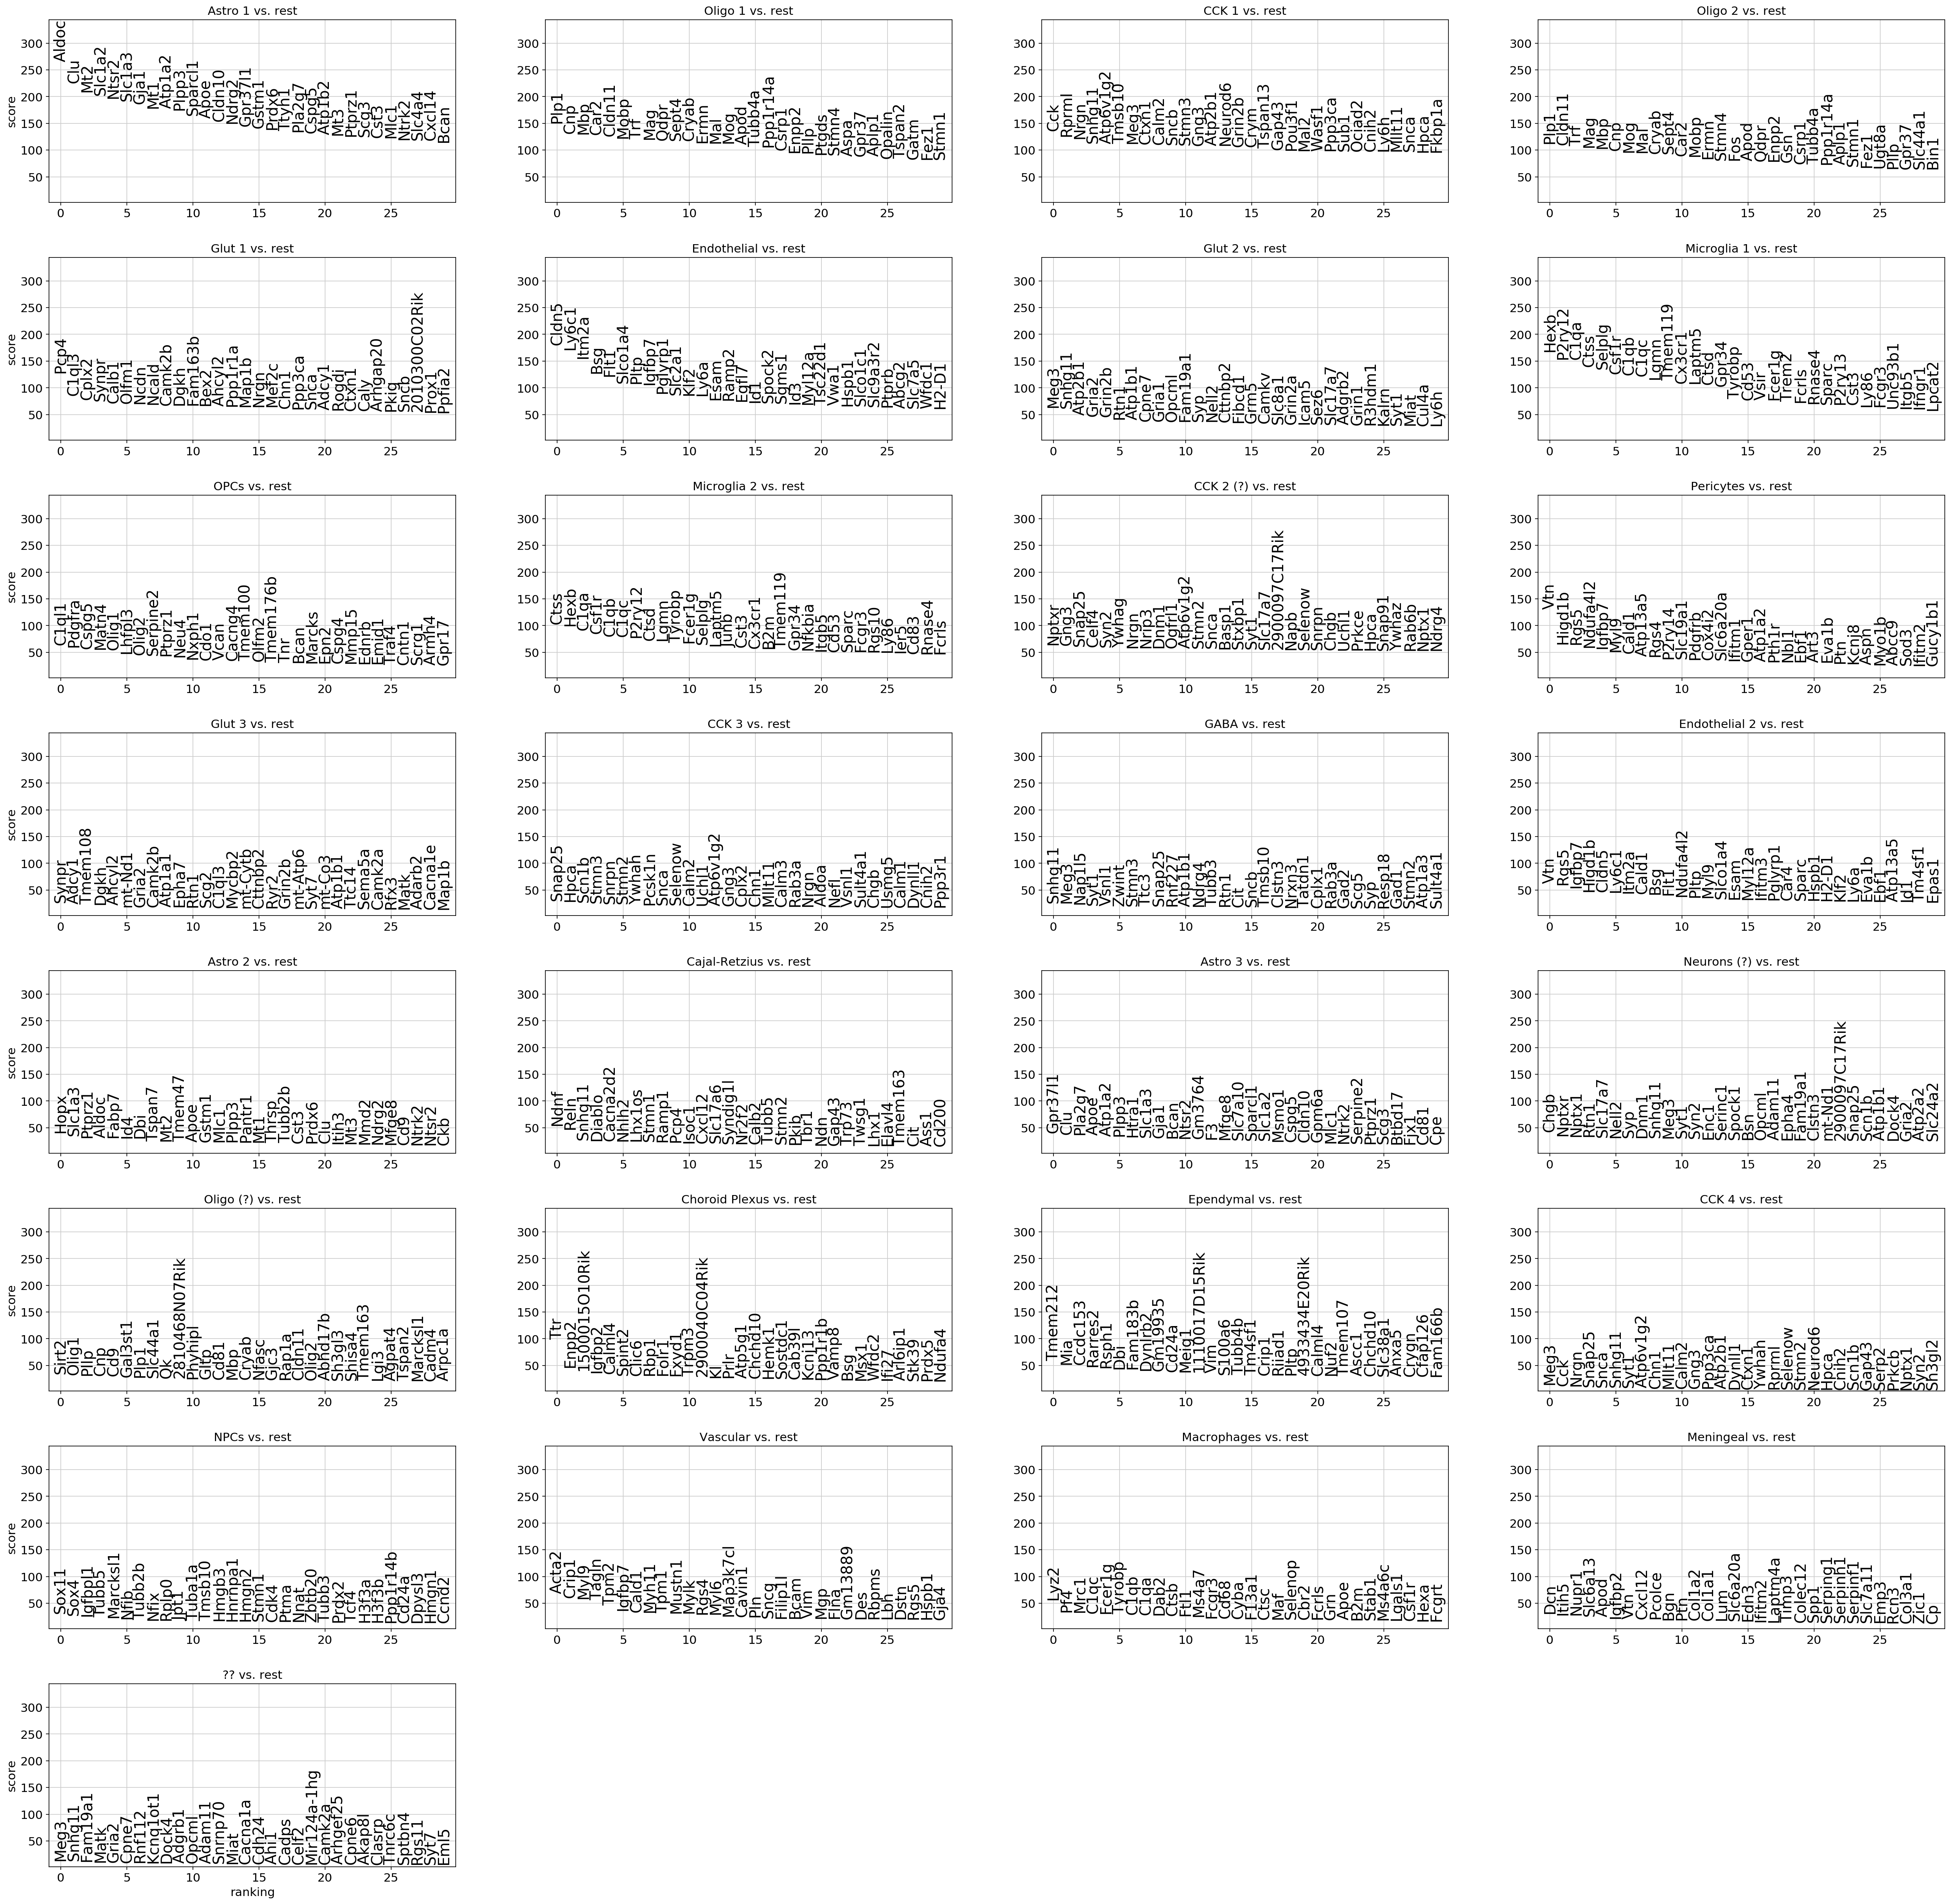

In [10]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata, n_genes=30, fontsize=18)

## Pairwise tests using diffxpy

Next, we set up pairwise testing for each cell type. Let us start with `ELS_ctrl` vs `BL_ctrl`.

In [16]:
adata.obs['condition'].value_counts()

ELS_Ctrl      7649
ELS_Stress    7517
BL_Stress     7050
BL_Ctrl       5951
Name: condition, dtype: int64

In [17]:
pd.crosstab(adata.obs['condition'],adata.obs['batch'])

batch,0,1,2,3,4,5,6,7,8,9,10,11
condition,,,,,,,,,,,,
BL_Ctrl,0,0,2184,0,0,3081,0,686,0,0,0,0
BL_Stress,0,0,0,0,2361,0,2646,0,0,0,0,2043
ELS_Ctrl,0,0,0,0,0,0,0,0,2970,2601,2078,0
ELS_Stress,2024,2785,0,2708,0,0,0,0,0,0,0,0


In [18]:
del adata.uns['baseline_colors']
del adata.uns['condition_colors']

KeyError: 'baseline_colors'

In [ ]:
del adata.uns['louvain_high_res_colors']
del adata.uns['louvain_colors']

In [19]:
adata

AnnData object with n_obs × n_vars = 28167 × 18928 
    obs: 'batch', 'sample_id', 'sample_name', 'baseline', 'condition', 'adult_stress', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'size_factors', 'louvain', 'louvain_high_res', 'S_score', 'G2M_score', 'phase', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'louvain', 'neighbors', 'pca', 'sample_name_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [28]:
adata_bl = adata_norm[adata.obs['baseline']=='BL']

In [29]:
pd.crosstab(adata_bl.obs['condition'],adata_bl.obs['sample_id'])

sample_id,ELS-11,ELS-27,ELS-47,ELS-71,ELS-103,ELS-105
condition,,,,,,
BL_Ctrl,2184,0,0,3081,0,686
BL_Stress,0,2646,2361,0,2043,0


In [30]:
de_results = dict()

In [31]:
de.utils.preview_coef_names(
    sample_description=adata_bl.obs,
    formula="~1 + condition + sample_id", 
)

['Intercept',
 'condition[T.BL_Stress]',
 'sample_id[T.ELS-27]',
 'sample_id[T.ELS-47]',
 'sample_id[T.ELS-71]',
 'sample_id[T.ELS-103]',
 'sample_id[T.ELS-105]']

In [35]:
for clust in adata_bl.obs['louvain'].cat.categories:
    adata_tmp = adata_bl[adata_bl.obs['louvain'] == clust,:].copy()
    if adata_tmp.shape[1] > 
    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=np.max((1,np.round(0.1*adata_tmp.n_obs).astype(int))))
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
        data=adata_tmp.layers['counts'],
        formula_loc="~ 1 + condition + size_factors + sample_id",
        as_numeric=['size_factors'],
        coef_to_test=["condition[T.BL_Stress]"],
        sample_description=adata_tmp.obs,
        gene_names=adata_tmp.var_names,
        noise_model='nb',
        dtype="float64"
    )
    
    #Store the results
    de_results[clust] = test_tmp
    

In cluster Astro 1:
BL_Stress    1323
BL_Ctrl       795
Name: condition, dtype: int64
filtered out 14736 genes that are detected in less than 212 cells
Testing 4192 genes...



ValueError: constrained design matrix is not full rank: 7 8

#### Check results

In [ ]:
de_results['Oligodendrocyte Progenitor Cells (OPCs)'].summary().sort_values(by='qval', 
                                                                            ascending=True).iloc[:10,:]

### Test with using replicate information

Rename batches to avoid underdetermined rank matrix.

In [45]:
adata_ctrl.obs['batch_match'] = adata_ctrl.obs['sample_id'].cat.add_categories(['A', 'B', 'C'])
adata_ctrl.obs['batch_match'][np.in1d(adata_ctrl.obs['batch_match'], ['ELS-11', 'ELS-73'])] = 'A' 
adata_ctrl.obs['batch_match'][np.in1d(adata_ctrl.obs['batch_match'], ['ELS-71', 'ELS-109'])] = 'B' 
adata_ctrl.obs['batch_match'][np.in1d(adata_ctrl.obs['batch_match'], ['ELS-105', 'ELS-113'])] = 'C' 
adata_ctrl.obs['batch_match'] = adata_ctrl.obs['batch_match'].cat.remove_unused_categories()

In [46]:
pd.crosstab(adata_ctrl.obs['condition'],adata_ctrl.obs['batch_match'])

batch_match,A,B,C
condition,,,
BL_Ctrl,2184,3081,686
ELS_Ctrl,2601,2078,2970


In [40]:
de_results = dict()

In [47]:
de.utils.preview_coef_names(
    sample_description=adata_ctrl.obs,
    formula="~1 + batch_match + condition + condition:batch_match", 
)

['Intercept',
 'batch_match[T.B]',
 'batch_match[T.C]',
 'condition[T.ELS_Ctrl]',
 'condition[T.ELS_Ctrl]:batch_match[T.B]',
 'condition[T.ELS_Ctrl]:batch_match[T.C]']

In [ ]:
for clust in adata_ctrl.obs['cell_type'].cat.categories:
    adata_tmp = adata_ctrl[adata_ctrl.obs['cell_type'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=np.max((1,np.round(0.05*adata_tmp.n_obs).astype(int))))
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
        data=adata_tmp.layers['counts'],
        formula_loc="~ 1 + batch_match + condition + condition:batch_match + size_factors",
        as_numeric=['size_factors'],
        coef_to_test=["condition[T.ELS_Ctrl]"],
        sample_description=adata_tmp.obs,
        gene_names=adata_tmp.var_names,
        noise_model='nb',
        dtype="float64"
    )
    
    #Store the results
    de_results[clust] = test_tmp
    

In cluster Oligodendrocyte Progenitor Cells (OPCs):
ELS_Ctrl    139
BL_Ctrl     112
Name: condition, dtype: int64
filtered out 11030 genes that are detected in less than 13 cells


I1126 09:38:52.812023 140136976942912 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


Testing 7898 genes...



In [ ]:
sample_condition = {'ELS-37': 'ELS_Stress_1',
 'ELS-7': 'ELS_Stress_2',
 'ELS-11': 'BL_Ctrl_1',
 'ELS-23': 'ELS_Stress_3',
 'ELS-47': 'BL_Stress_1',
 'ELS-71': 'BL_Ctrl_2',
 'ELS-27': 'BL_Stress_2',
 'ELS-105': 'BL_Ctrl_3',
 'ELS-113': 'ELS_Ctrl_1',
 'ELS-73': 'ELS_Ctrl_2',
 'ELS-109': 'ELS_Ctrl_3',
 'ELS-103': 'BL_Stress_3'}

In [40]:
adata_bl.obs['batch_match'] = adata_bl.obs['sample_id'].cat.add_categories(['A', 'B', 'C'])
adata_bl.obs['batch_match'][np.in1d(adata_bl.obs['batch_match'], ['ELS-11', 'ELS-47'])] = 'A' 
adata_bl.obs['batch_match'][np.in1d(adata_bl.obs['batch_match'], ['ELS-71', 'ELS-27'])] = 'B' 
adata_bl.obs['batch_match'][np.in1d(adata_bl.obs['batch_match'], ['ELS-105', 'ELS-103'])] = 'C' 
adata_bl.obs['batch_match'] = adata_bl.obs['batch_match'].cat.remove_unused_categories()

In [41]:
pd.crosstab(adata_bl.obs['condition'],adata_bl.obs['batch_match'])

batch_match,A,B,C
condition,,,
BL_Ctrl,2184,3081,686
BL_Stress,2361,2646,2043


In [42]:
de_results = dict()

In [44]:
de.utils.preview_coef_names(
    sample_description=adata_bl.obs,
    formula="~1 + batch_match + condition + condition:batch_match", 
)

['Intercept',
 'batch_match[T.B]',
 'batch_match[T.C]',
 'condition[T.BL_Stress]',
 'condition[T.BL_Stress]:batch_match[T.B]',
 'condition[T.BL_Stress]:batch_match[T.C]']

In [50]:
for clust in adata_bl.obs['cell_type'].cat.categories:
    adata_tmp = adata_bl[adata_bl.obs['cell_type'] == clust,:].copy()
    if adata_tmp.shape[1] > 500:
        print(f'In cluster {clust}:')
        print(adata_tmp.obs.condition.value_counts())
    
        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp, min_cells=np.max((1,np.round(0.15*adata_tmp.n_obs).astype(int))))
        print(f'Testing {adata_tmp.n_vars} genes...')
        print("")
        
        test_tmp = de.test.wald(
            data=adata_tmp.layers['counts'],
            formula_loc="~ 1 + batch_match + condition + condition:batch_match + size_factors",
            as_numeric=['size_factors'],
            coef_to_test=["condition[T.BL_Stress]"],
            sample_description=adata_tmp.obs,
            gene_names=adata_tmp.var_names,
            noise_model='nb',
            dtype="float64"
        )
        
        #Store the results
        de_results[clust] = test_tmp
        

In cluster Oligodendrocyte Progenitor Cells (OPCs):
BL_Stress    284
BL_Ctrl      112
Name: condition, dtype: int64
filtered out 15199 genes that are detected in less than 59 cells
Testing 3729 genes...

iter   0: ll=20141357.897329
iter   1: ll=20074990.027623, converged: 0.00% (loc: 0.00%, scale update: False), in 0.66sec
iter   2: ll=20069614.163491, converged: 0.00% (loc: 17.91%, scale update: False), in 0.68sec
iter   3: ll=20069321.644897, converged: 0.00% (loc: 17.91%, scale update: False), in 0.71sec
iter   4: ll=20069262.925317, converged: 0.00% (loc: 20.25%, scale update: False), in 0.86sec
iter   5: ll=20069243.086854, converged: 0.00% (loc: 66.91%, scale update: False), in 0.71sec
iter   6: ll=20069235.936759, converged: 0.00% (loc: 86.75%, scale update: False), in 0.97sec
iter   7: ll=20069233.311981, converged: 0.00% (loc: 87.96%, scale update: False), in 0.99sec
iter   8: ll=20069232.346178, converged: 0.00% (loc: 88.07%, scale update: False), in 0.92sec
iter   9: ll=200

ValueError: constrained design matrix is not full rank: 6 7